In [5]:
%pip install numpy
%pip install pandas
%pip install scipy
%pip install seaborn
%pip install matplotlib
%pip install scikit-learn
%pip install tensorflow
%pip install keras
%pip install biosppy
%pip install peakutils
%pip install --upgrade setuptools pip

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import matplotlib as plt
from matplotlib import pyplot
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import os
import math
from math import *
import sys
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from biosppy.signals import ecg

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.decomposition import PCA

import tensorflow

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.layers import concatenate
from keras.utils import to_categorical


from keras.optimizers import SGD, Adam
from keras.models import load_model

In [7]:
# Set filepath
filepath = 'PTB_processed_new'
completed = 0
total = len(os.listdir(filepath))
# Load label file
labels_file = pd.read_csv("new_labels_processed.csv", header = 0)
labels = np.asarray(labels_file['diagnosis'])
# Create empty containers
signal_array = [] # To store all segments
label_array = [] # TO store all labels
# Create counters
no_segment = 0
files_completed = 0
file_number = 0
# Signal Extractor
start_time = time.time()
for filename in os.listdir(filepath):
    start_time_file = time.time()
    data = pd.read_csv(filepath + '/' + filename, header = 0, engine = 'python')
    file_label = labels[file_number]
    df = np.array(data['v4'])
    peaks = ecg.christov_segmenter(df, 1000)[0]
    for peak in range (1, len(peaks) - 1):
        segment_array = [] # To store 1 segment
        for column in data:
            df = np.array(data[column])
            segment = df[peaks[peak]-50:peaks[peak]+100]
            segment_array.append(segment)
        signal_array.append(segment_array)
        label_array.append(file_label)
        no_segment += 1
    files_completed += 1
    file_number += 1
    progress = files_completed / total * 100
    progress = round(progress, 2)
    end_time_file = time.time()
    elasped_time_file = round(end_time_file - start_time_file, 2)
    sys.stdout.write('\r'+filename + ' loaded - ' + str(progress) + '% completed' + ' - Took: ' + str(elasped_time_file) + ' seconds')


signal_array = np.asarray(signal_array).reshape(-1, 150, 12)
end_time = time.time()
elasped_time = round(end_time - start_time, 2)
print('')
print ('Data loading completed ' + str(files_completed) + ' files loaded with ' + str(no_segment) + ' signal segments' + ' - Took: ' + str(elasped_time) + ' seconds')

record513_patient294_Myocardial infarction.csv loaded - 100.0% completed - Took: 0.18 secondss
Data loading completed 513 files loaded with 8996 signal segments - Took: 86.03 seconds


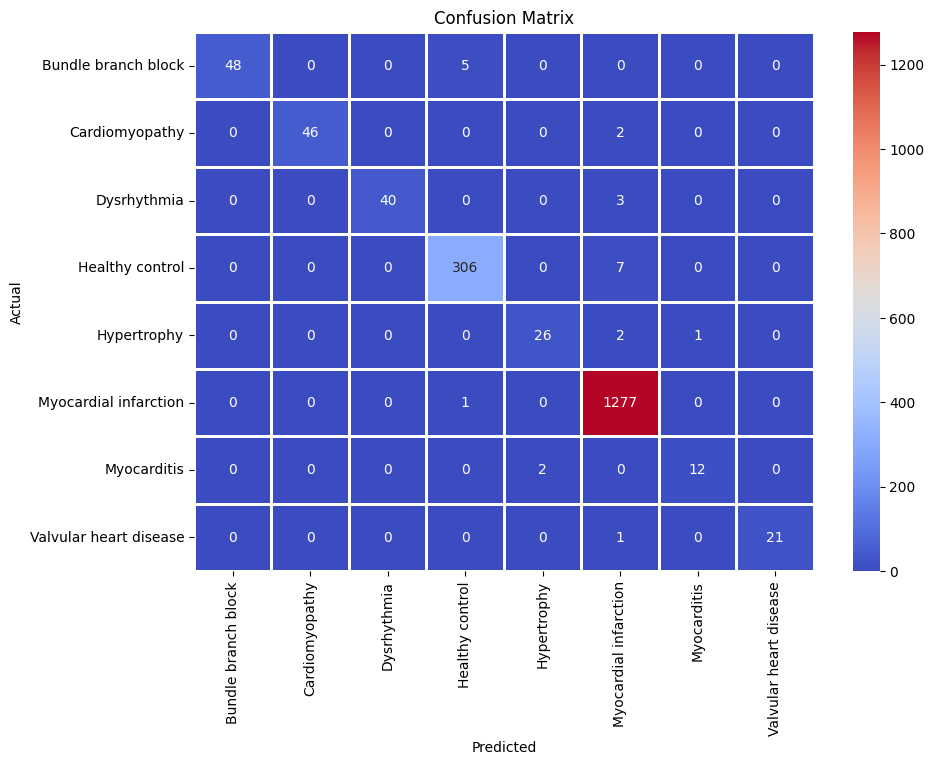

Classification Report:
                        precision    recall  f1-score   support

   Bundle branch block       1.00      0.91      0.95        53
        Cardiomyopathy       1.00      0.96      0.98        48
           Dysrhythmia       1.00      0.93      0.96        43
       Healthy control       0.98      0.98      0.98       313
           Hypertrophy       0.93      0.90      0.91        29
 Myocardial infarction       0.99      1.00      0.99      1278
           Myocarditis       0.92      0.86      0.89        14
Valvular heart disease       1.00      0.95      0.98        22

              accuracy                           0.99      1800
             macro avg       0.98      0.93      0.96      1800
          weighted avg       0.99      0.99      0.99      1800



In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label_array)

# Split data
X_train, X_test, y_train, y_test = train_test_split(signal_array, encoded_labels, test_size=0.2, random_state=42)

# Flatten the data for classification (since RandomForestClassifier does not support 3D input)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train a classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_flat, y_train)

# Make predictions
y_pred = clf.predict(X_test_flat)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', linecolor='white', linewidths=1, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
